# Group Connection Testing


In [98]:
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from graspologic.plot import heatmap, adjplot
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations

In [99]:
folder = _get_folder()
annotations = load_connectome_normal_lcc_annotations()
annotations

,skids,side,class,segment,type,group
0,2015233,l,s,head,100.0,NaN
1,1548290,l,NaN,1,NaN,NaN
2,1318919,l,s,head,88.0,15.0
3,2015241,l,s,head,100.0,NaN
4,1646603,r,NaN,3,NaN,NaN
...,...,...,...,...,...,...
2696,1302513,l,s,head,NaN,NaN
2697,1630186,l,NaN,2,NaN,NaN
2698,1441779,r,NaN,head,NaN,NaN
2699,1671147,r,m,1,165.0,NaN


In [59]:
#get skids for l, r, head, pygidium, 0, 1, 2, 3

skids_hemis = {"l": [], "r": []}
labels_hemis = {"l": [], "r": []}
skids_segs = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
labels_segs = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
poss_labels = ["s", "i", "m"]

#add skids and labels for hemis
for key in skids_hemis:
    for i in range(len(annotations["skids"])):
        if(annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis[key].append(annotations["skids"][i])
            labels_hemis[key].append(annotations["class"][i])

#add skids and labels for segments
for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs[key].append(annotations["skids"][i])
            labels_segs[key].append(annotations["class"][i])

#dictionaries to dfs
skids_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis.items()]))
labels_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_hemis.items()]))
skids_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs.items()]))
labels_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_segs.items()]))

#save dfs as csvs to get the adjs in gen_data

skids_hemis_df.to_csv(folder / "skids_hemi_classes.csv")
labels_hemis_df.to_csv(folder / "labels_hemi_classes.csv")
skids_segs_df.to_csv(folder / "skids_segs_classes.csv")
labels_segs_df.to_csv(folder / "labels_segs_classes.csv")



In [47]:
#comparison for hemis
count_hemis = {"l" : {"s": 0, "i": 0, "m": 0}, "r": {"s": 0, "i": 0, "m": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis[key])):
        count_hemis[key][labels_hemis[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_hemis = []
class_label_hemis = []
hemi_label = []
# loop through "l" and "r"
for key in count_hemis:
    # loop through "s", "i", "m"
    for inner_key in count_hemis[key]:
        # append "s" "i" or "m"
        class_label_hemis.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_hemis.append(count_hemis[key][inner_key])
        # append the outer key from count_hemis
        hemi_label.append(key)

label_counts = list(zip(class_label_hemis, list_counts_hemis, hemi_label))
df_hemis = pd.DataFrame(label_counts, columns = ["class", "count", "side"])
df_hemis.to_csv(folder / "hemi_classes.csv")
df_hemis

,class,count,side
0,s,283,l
1,i,478,l
2,m,108,l
3,s,272,r
4,i,497,r
5,m,121,r


<AxesSubplot:xlabel='class', ylabel='count'>

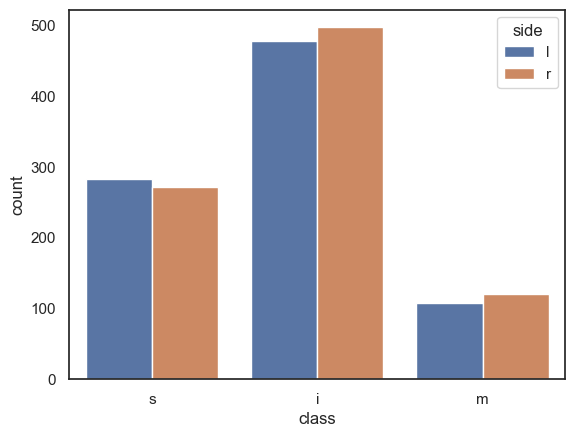

In [39]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df_hemis)

In [44]:
#comparison for hemis
count_segs = {"head" : {"s": 0, "i": 0, "m": 0},
              "pygidium": {"s": 0, "i": 0, "m": 0},
              "0" : {"s": 0, "i": 0, "m": 0},
              "1" : {"s": 0, "i": 0, "m": 0},
              "2" : {"s": 0, "i": 0, "m": 0},
              "3" : {"s": 0, "i": 0, "m": 0},}

for key in count_segs:
    for i in range(len(labels_segs[key])):
        count_segs[key][labels_segs[key][i]] += 1
print(count_segs)
# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_segs = []
class_label_segs = []
segs_label = []
# loop through "l" and "r"
for key in count_segs:
    # loop through "s", "i", "m"
    for inner_key in count_segs[key]:
        # append "s" "i" or "m"
        class_label_segs.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_segs.append(count_segs[key][inner_key])
        # append the outer key from count_hemis
        segs_label.append(key)

label_counts_segs = list(zip(class_label_segs, list_counts_segs, segs_label))
df_segs = pd.DataFrame(label_counts_segs, columns = ["class", "count", "segment"])
df_segs

{'head': {'s': 375, 'i': 432, 'm': 20}, 'pygidium': {'s': 44, 'i': 18, 'm': 2}, '0': {'s': 15, 'i': 8, 'm': 1}, '1': {'s': 35, 'i': 163, 'm': 58}, '2': {'s': 44, 'i': 203, 'm': 83}, '3': {'s': 42, 'i': 152, 'm': 66}}


,class,count,segment
0,s,375,head
1,i,432,head
2,m,20,head
3,s,44,pygidium
4,i,18,pygidium
5,m,2,pygidium
6,s,15,0
7,i,8,0
8,m,1,0
9,s,35,1


<AxesSubplot:xlabel='class', ylabel='count'>

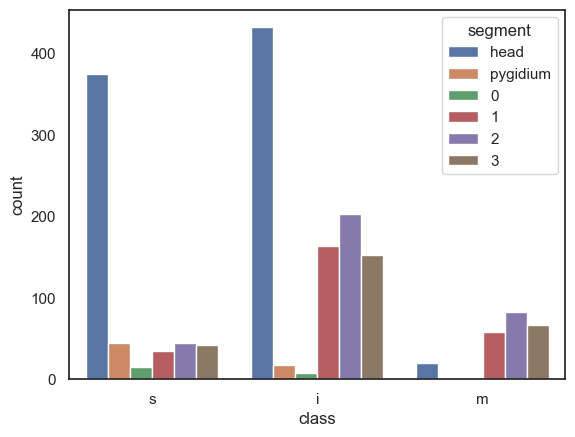

In [45]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="segment", data=df_segs)

In [2]:
from pkg.platy import load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels, load_right_adj_labels, load_left_adj_labels, load_head_adj_labels, load_pygidium_adj_labels

#block for loading adjs/labels

#hemis
left_adj, left_labels = load_left_adj_labels()
right_adj, right_labels = load_right_adj_labels()

#segments
head_adj, head_labels = load_head_adj_labels()
pyg_adj, pyg_labels = load_pygidium_adj_labels()
adj_0, labels_0 = load_0_adj_labels()
adj_1, labels_1 = load_1_adj_labels()
adj_2, labels_2 = load_2_adj_labels()
adj_3, labels_3 = load_3_adj_labels()

In [96]:
#lists for adjs/labels/anems
hemi_adjs = [left_adj, right_adj]
for i, val in enumerate(hemi_adjs):
    hemi_adjs[i] = val.to_numpy()
segment_adjs = [head_adj, pyg_adj, adj_0, adj_1, adj_2, adj_3]
for i, val in enumerate(segment_adjs):
    segment_adjs[i] = val.to_numpy()
all_adjs = hemi_adjs + segment_adjs

hemi_labels = [left_labels, right_labels]
segment_labels = [head_labels, pyg_labels, labels_0, labels_1, labels_2, labels_3]
all_labels = hemi_labels + segment_labels

hemi_names = ["left", "right"]
segment_names = ["head", "pygidium", '0', "1", "2", "3"]
all_names = hemi_names + segment_names

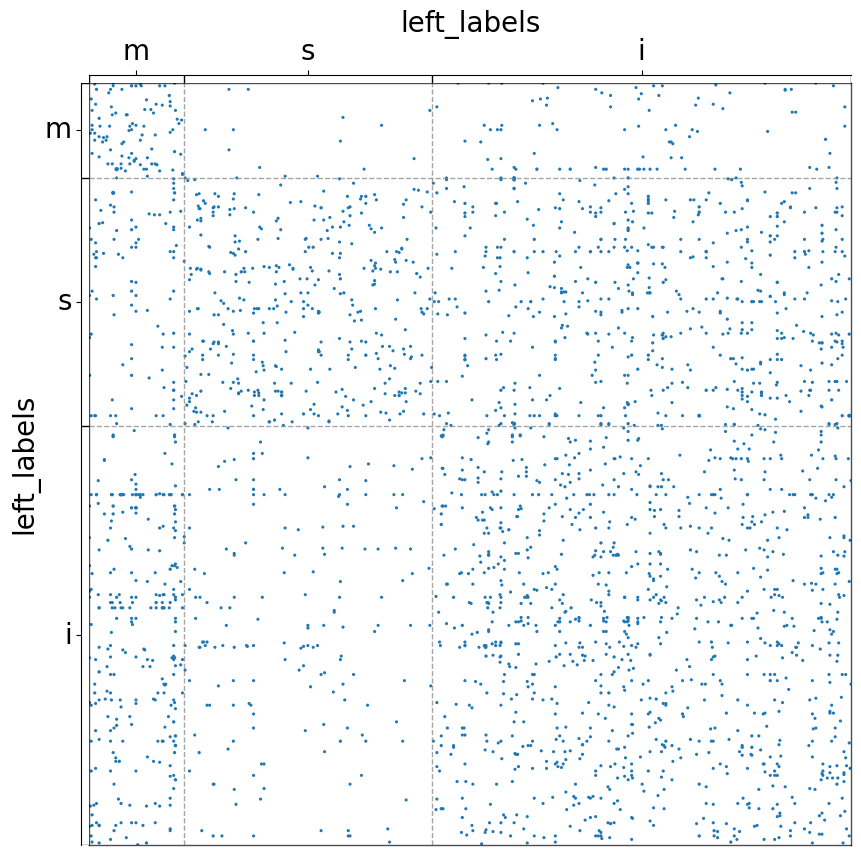

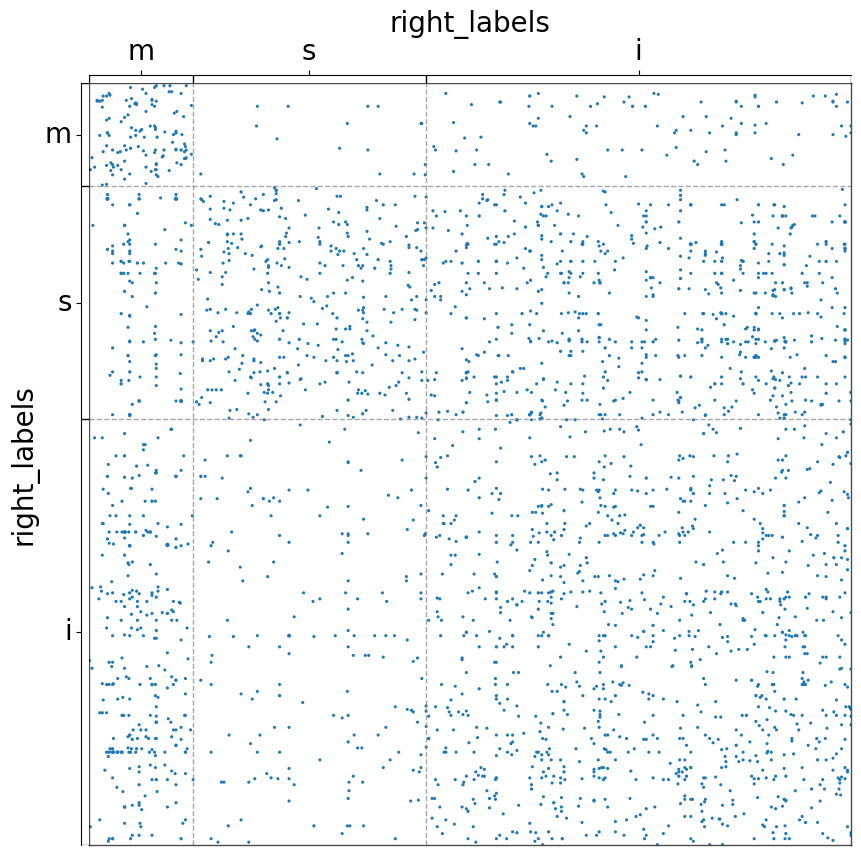

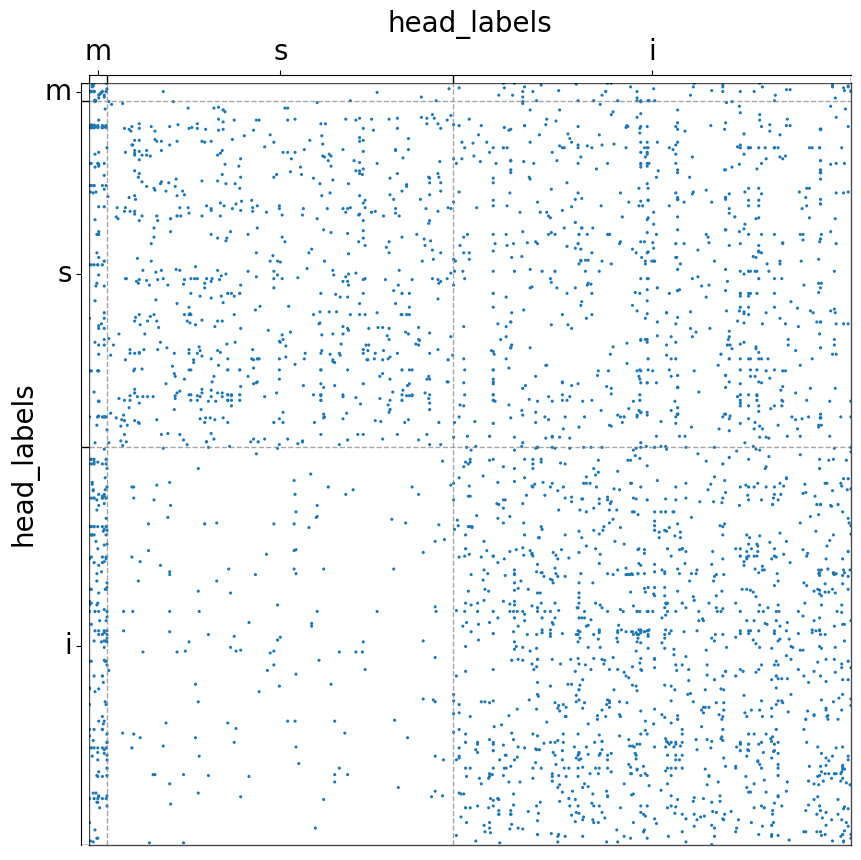

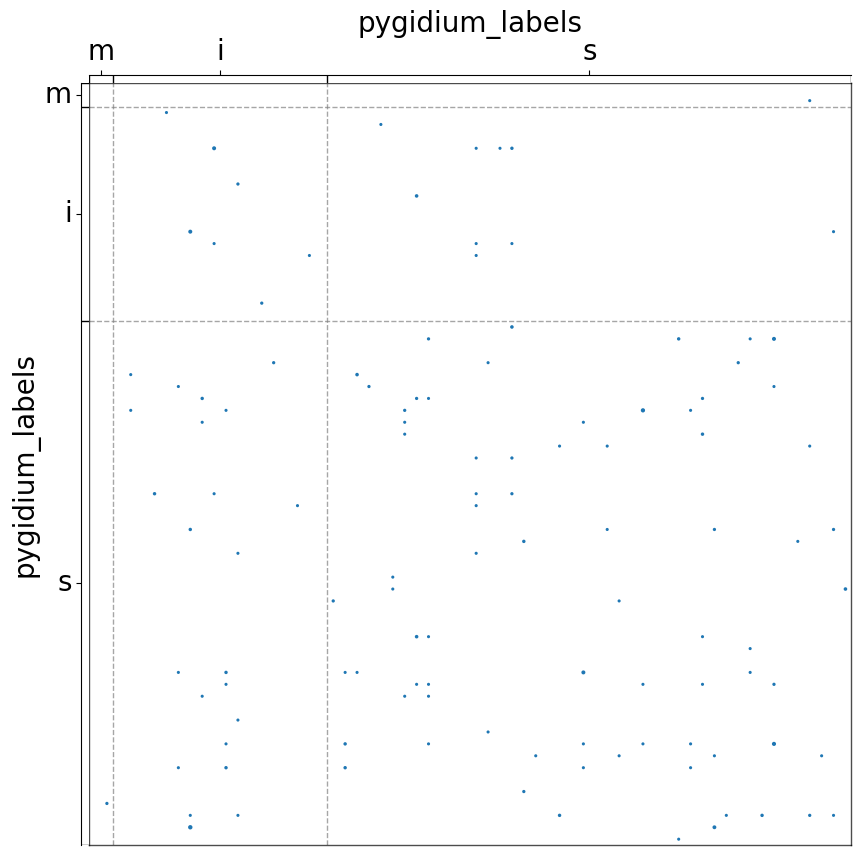

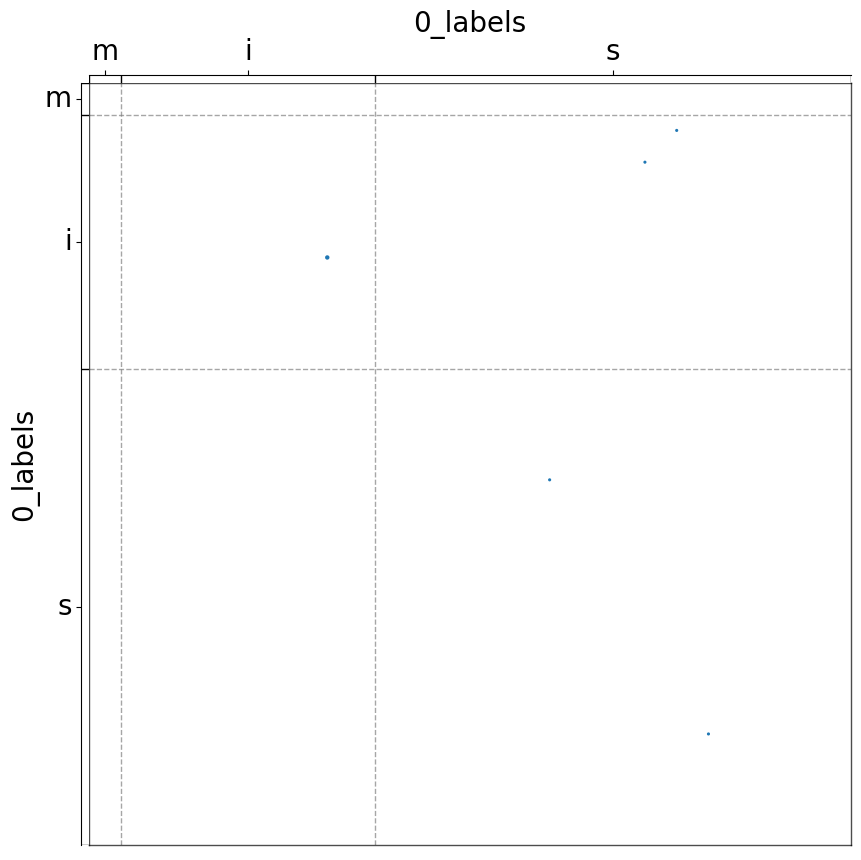

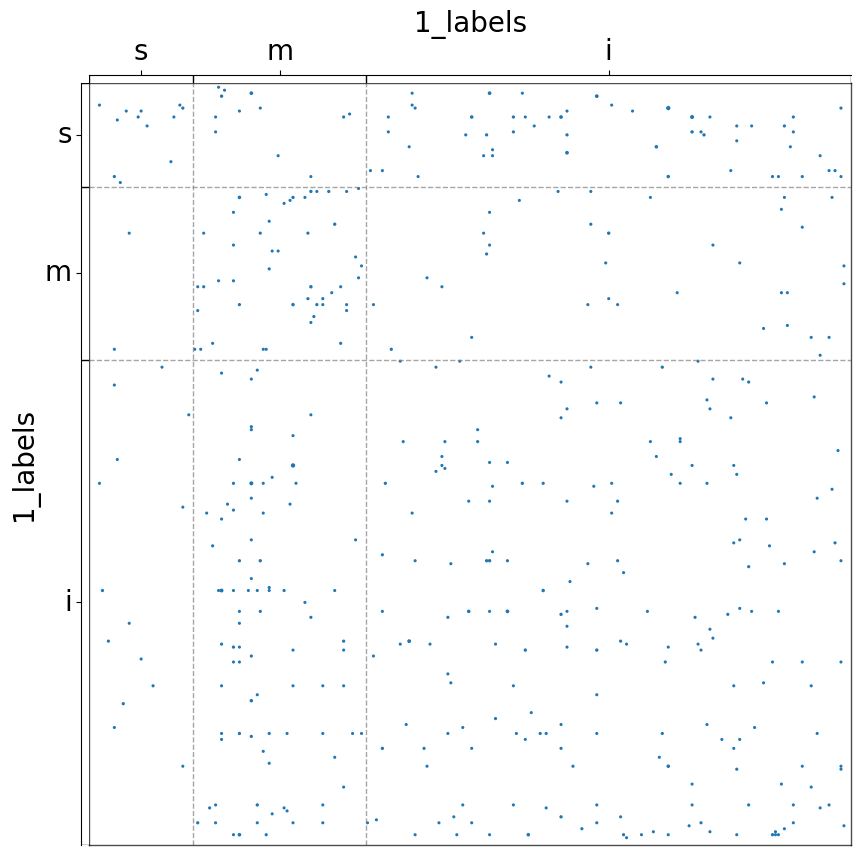

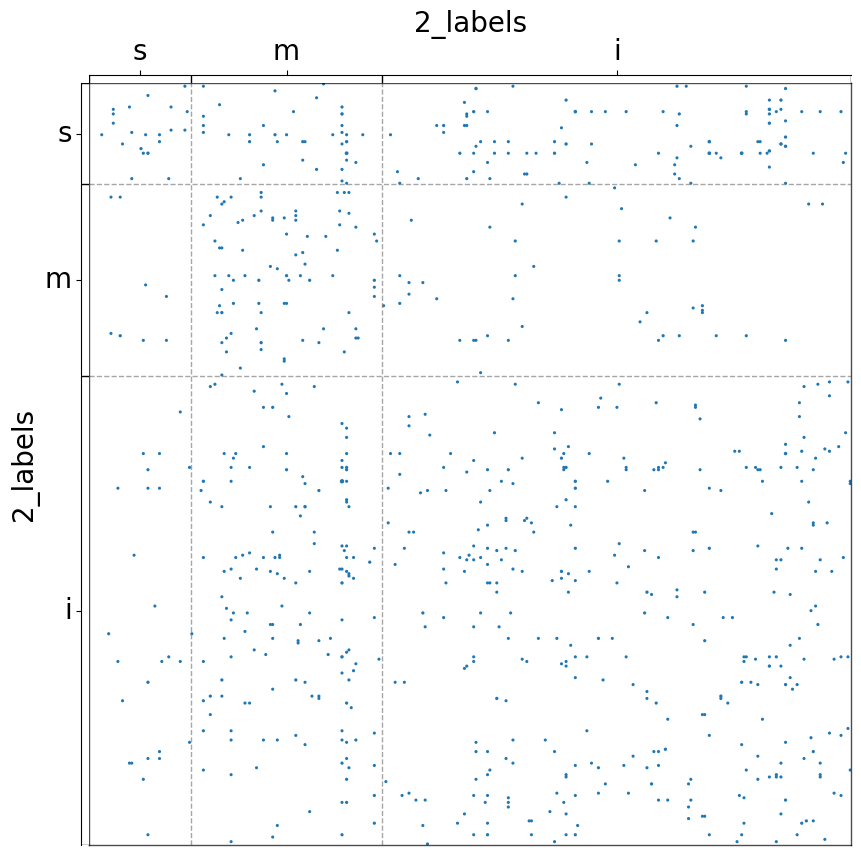

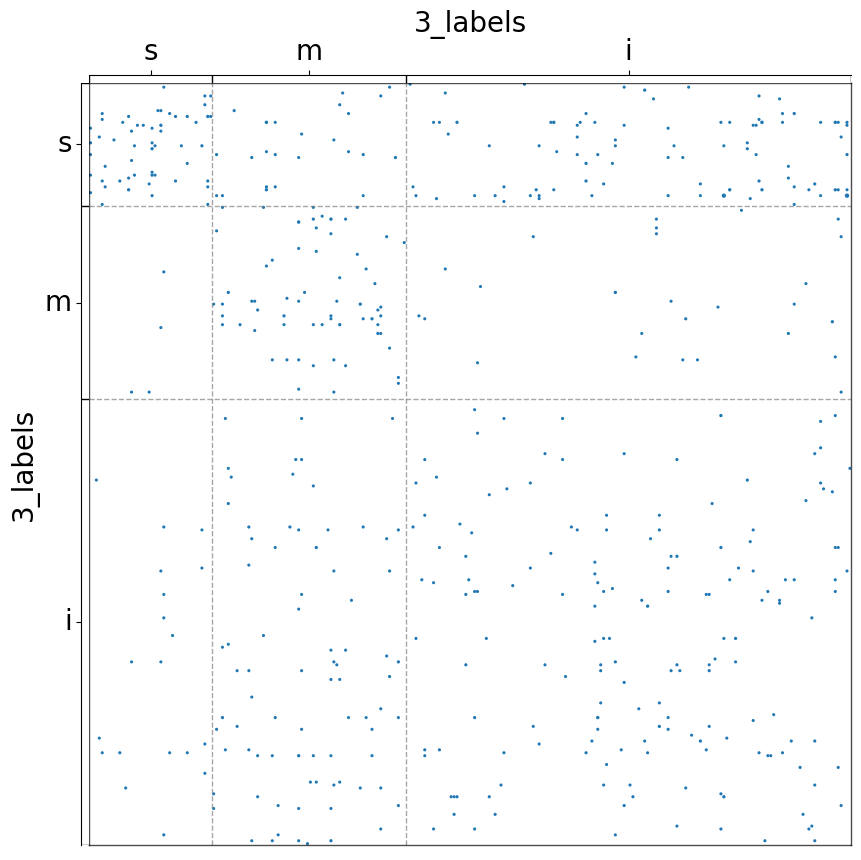

In [106]:
#scatterplots

#metadata
metas = []
for i in range(len(all_adjs)):
    metas.append(pd.DataFrame(
        data={
              "{}_labels".format(all_names[i]): all_labels[i]
        },
))

for i in range(len(all_adjs)):
    adjplot(all_adjs[i], plot_type="scattermap", meta=metas[i], group=["{}_labels".format(all_names[i])])
    plt.savefig(folder / "group_connection_plots" / "scatterplots" / "connection_{}".format(all_names[i]))

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
36.0


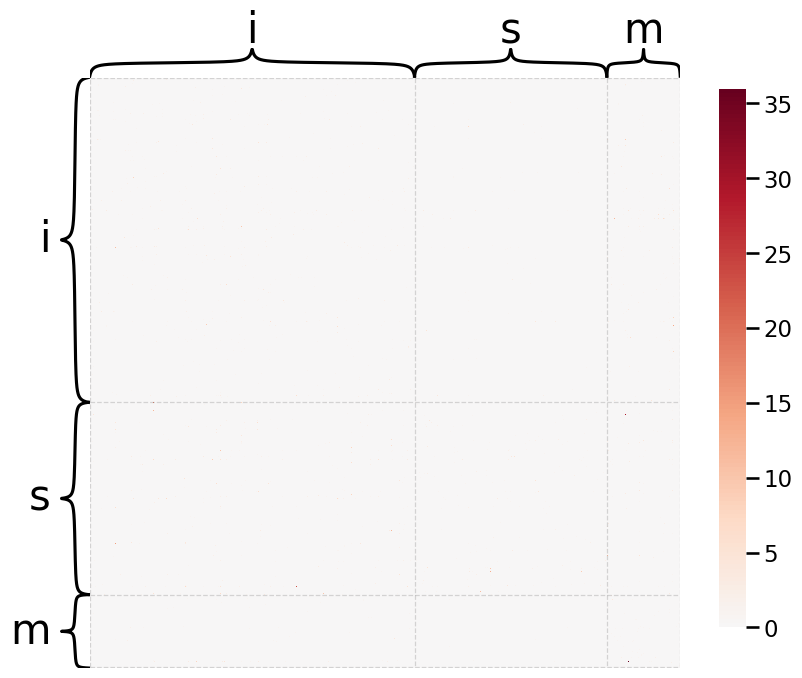

In [13]:
#heatmaps
np_left = left_adj.to_numpy()
np_right = right_adj.to_numpy()
heatmap(np_left, inner_hier_labels=left_labels)
print(np_left)
max = 0
for i in range(len(np_left)):
    for j in range(len(np_left[0])):
        if(np_left[i][j] > max):
            max = np_left[i][j]
print(max)

In [12]:
stat, pval, misc = group_connection_test(np_left, np_right, left_labels, right_labels)
pval

0.17066316345772808

In [16]:
# skids_left = pymaid.get_skids_by_annotation("left")
# skids_right = pymaid.get_skids_by_annotation("right")
# skids_head = pymaid.get_skids_by_annotation("head")
# skids_pygidium = pymaid.get_skids_by_annotation("pygidium")
# skids_0 = pymaid.get_skids_by_annotation("segment_0")
# skids_1 = pymaid.get_skids_by_annotation("segment_1")
# skids_2 = pymaid.get_skids_by_annotation("segment_2")
# skids_3 = pymaid.get_skids_by_annotation("segment_3")

In [8]:
#don't think i need this
# df_left = pymaid.adjacency_matrix(skids_left)
# df_right = pymaid.adjacency_matrix(skids_right)
# df_head = pymaid.adjacency_matrix(skids_head)
# df_pygidium = pymaid.adjacency_matrix(skids_pygidium)
# df_0 = pymaid.adjacency_matrix(skids_0)
# df_1 = pymaid.adjacency_matrix(skids_1)
# df_2 = pymaid.adjacency_matrix(skids_2)
# df_3 = pymaid.adjacency_matrix(skids_3)

In [9]:
# skids_sensory = pymaid.get_skids_by_annotation("Sensory neuron")
# skids_inter = pymaid.get_skids_by_annotation("interneuron")
# skids_motor = pymaid.get_skids_by_annotation("motorneuron")

In [10]:
# def class_labels(skids, skids_sensory, skids_inter, skids_motor):
#     new_skids = []
#     labels = []
#     for i, skid in enumerate(skids):
#         if skid in skids_sensory:
#             labels.append("s")
#             new_skids.append(skid)
#         elif skid in skids_inter:
#             labels.append("i")
#             new_skids.append(skid)
#         elif skid in skids_motor:
#             labels.append("m")
#             new_skids.append(skid)

#     return new_skids, labels

In [11]:
# left_new, left_labels = class_labels(skids_left, skids_sensory, skids_inter, skids_motor)
# right_new, right_labels = class_labels(skids_right, skids_sensory, skids_inter, skids_motor)
# head_new, head_labels = class_labels(skids_head, skids_sensory, skids_inter, skids_motor)
# pygidium_new, pygidium_labels = class_labels(skids_pygidium, skids_sensory, skids_inter, skids_motor)
# seg0_new, seg0_labels = class_labels(skids_0, skids_sensory, skids_inter, skids_motor)
# seg1_new, seg1_labels = class_labels(skids_1, skids_sensory, skids_inter, skids_motor)
# seg2_new, seg2_labels = class_labels(skids_2, skids_sensory, skids_inter, skids_motor)
# seg3_new, seg3_labels = class_labels(skids_3, skids_sensory, skids_inter, skids_motor)
# len(seg0_new)

In [12]:
# df_left = pymaid.adjacency_matrix(left_new)
# df_right = pymaid.adjacency_matrix(right_new)
# df_head = pymaid.adjacency_matrix(head_new)
# df_pygidium = pymaid.adjacency_matrix(pygidium_new)
# df_0 = pymaid.adjacency_matrix(seg0_new)
# df_1 = pymaid.adjacency_matrix(seg1_new)
# df_2 = pymaid.adjacency_matrix(seg2_new)
# df_3 = pymaid.adjacency_matrix(seg3_new)

In [13]:
# left_adj = df_left.to_numpy()
# right_adj = df_right.to_numpy()
# head_adj = df_head.to_numpy()
# pygidium_adj = df_pygidium.to_numpy()
# seg0_adj = df_0.to_numpy()
# seg1_adj = df_1.to_numpy()
# seg2_adj = df_2.to_numpy()
# seg3_adj = df_3.to_numpy()

In [14]:
# all_adjs = [left_adj, right_adj, head_adj, pygidium_adj, seg0_adj, seg1_adj, seg2_adj, seg3_adj]
# pairwise_adjs = list(itertools.combinations(all_adjs, 2))
# len(pairwise_adjs)

In [15]:
# stat, pval, misc = group_connection_test(left_adj, right_adj, left_labels, right_labels)
# pval